# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 19.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 12.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 21.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 620 kB/s eta 0:00:011
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [9]:
client = MongoClient(mongod_connect)
db = client.gp13 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [10]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = [''] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [12]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [13]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5246403,-77.5633018,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                             #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [14]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Sun Nov 22 17:56:29 +0000 2020'
'Sun Nov 22 17:56:27 +0000 2020'
'Sun Nov 22 17:56:21 +0000 2020'
'Sun Nov 22 17:56:20 +0000 2020'
'Sun Nov 22 17:56:15 +0000 2020'
'Sun Nov 22 17:56:00 +0000 2020'
'Sun Nov 22 17:55:54 +0000 2020'
'Sun Nov 22 17:55:36 +0000 2020'
'Sun Nov 22 17:55:10 +0000 2020'
'Sun Nov 22 17:54:33 +0000 2020'
'Sun Nov 22 17:54:29 +0000 2020'
'Sun Nov 22 17:54:17 +0000 2020'
'Sun Nov 22 17:54:14 +0000 2020'
'Sun Nov 22 17:54:09 +0000 2020'
'Sun Nov 22 17:54:08 +0000 2020'
'Sun Nov 22 17:54:07 +0000 2020'
'Sun Nov 22 17:54:00 +0000 2020'
'Sun Nov 22 17:53:56 +0000 2020'
'Sun Nov 22 17:53:40 +0000 2020'
'Sun Nov 22 17:53:34 +0000 2020'
'Sun Nov 22 17:53:31 +0000 2020'
'Sun Nov 22 17:53:30 +0000 2020'
'Sun Nov 22 17:53:24 +0000 2020'
'Sun Nov 22 17:53:16 +0000 2020'
'Sun Nov 22 17:53:13 +0000 2020'
'Sun Nov 22 17:53:03 +0000 2020'
'Sun Nov 22 17:52:56 +0000 2020'
'Sun Nov 22 17:52:56 +0000 2020'
'Sun Nov 22 17:52:49 +0000 2020'
'Sun Nov 22 17:52:42 +0000 2020'
'Sun Nov 2

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [16]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Sun Nov 22 17:07:31 +0000 2020'
'Sun Nov 22 17:07:25 +0000 2020'
'Sun Nov 22 17:07:23 +0000 2020'
'Sun Nov 22 17:07:22 +0000 2020'
'Sun Nov 22 17:07:16 +0000 2020'
'Sun Nov 22 17:07:15 +0000 2020'
'Sun Nov 22 17:07:15 +0000 2020'
'Sun Nov 22 17:07:13 +0000 2020'
'Sun Nov 22 17:07:12 +0000 2020'
'Sun Nov 22 17:07:10 +0000 2020'
'Sun Nov 22 17:07:08 +0000 2020'
'Sun Nov 22 17:07:07 +0000 2020'
'Sun Nov 22 17:07:06 +0000 2020'
'Sun Nov 22 17:06:58 +0000 2020'
'Sun Nov 22 17:06:50 +0000 2020'
'Sun Nov 22 17:06:46 +0000 2020'
'Sun Nov 22 17:06:13 +0000 2020'
'Sun Nov 22 17:06:12 +0000 2020'
'Sun Nov 22 17:06:11 +0000 2020'
'Sun Nov 22 17:06:11 +0000 2020'
'Sun Nov 22 17:06:09 +0000 2020'
'Sun Nov 22 17:06:09 +0000 2020'
'Sun Nov 22 17:06:07 +0000 2020'
'Sun Nov 22 17:05:56 +0000 2020'
'Sun Nov 22 17:05:53 +0000 2020'
'Sun Nov 22 17:05:47 +0000 2020'
'Sun Nov 22 17:05:42 +0000 2020'
'Sun Nov 22 17:05:41 +0000 2020'
'Sun Nov 22 17:05:38 +0000 2020'
'Sun Nov 22 17:05:32 +0000 2020'
'Sun Nov 2

'Sun Nov 22 16:31:28 +0000 2020'
'Sun Nov 22 16:31:24 +0000 2020'
'Sun Nov 22 16:31:17 +0000 2020'
'Sun Nov 22 16:31:08 +0000 2020'
'Sun Nov 22 16:31:04 +0000 2020'
'Sun Nov 22 16:31:02 +0000 2020'
'Sun Nov 22 16:31:01 +0000 2020'
'Sun Nov 22 16:30:58 +0000 2020'
'Sun Nov 22 16:30:45 +0000 2020'
'Sun Nov 22 16:30:42 +0000 2020'
'Sun Nov 22 16:30:34 +0000 2020'
'Sun Nov 22 16:30:28 +0000 2020'
'Sun Nov 22 16:30:25 +0000 2020'
'Sun Nov 22 16:30:23 +0000 2020'
'Sun Nov 22 16:30:23 +0000 2020'
'Sun Nov 22 16:30:19 +0000 2020'
'Sun Nov 22 16:30:08 +0000 2020'
'Sun Nov 22 16:30:01 +0000 2020'
'Sun Nov 22 16:29:59 +0000 2020'
'Sun Nov 22 16:29:57 +0000 2020'
'Sun Nov 22 16:29:42 +0000 2020'
'Sun Nov 22 16:29:42 +0000 2020'
'Sun Nov 22 16:29:30 +0000 2020'
'Sun Nov 22 16:29:25 +0000 2020'
'Sun Nov 22 16:29:17 +0000 2020'
'Sun Nov 22 16:29:05 +0000 2020'
'Sun Nov 22 16:28:24 +0000 2020'
'Sun Nov 22 16:28:09 +0000 2020'
'Sun Nov 22 16:28:05 +0000 2020'
'Sun Nov 22 16:28:04 +0000 2020'
'Sun Nov 2

'Sun Nov 22 15:41:33 +0000 2020'
'Sun Nov 22 15:41:32 +0000 2020'
'Sun Nov 22 15:41:29 +0000 2020'
'Sun Nov 22 15:41:17 +0000 2020'
'Sun Nov 22 15:41:13 +0000 2020'
'Sun Nov 22 15:41:07 +0000 2020'
'Sun Nov 22 15:41:04 +0000 2020'
'Sun Nov 22 15:41:03 +0000 2020'
'Sun Nov 22 15:40:55 +0000 2020'
'Sun Nov 22 15:40:54 +0000 2020'
'Sun Nov 22 15:40:47 +0000 2020'
'Sun Nov 22 15:40:45 +0000 2020'
'Sun Nov 22 15:40:44 +0000 2020'
'Sun Nov 22 15:40:43 +0000 2020'
'Sun Nov 22 15:40:38 +0000 2020'
'Sun Nov 22 15:40:29 +0000 2020'
'Sun Nov 22 15:40:21 +0000 2020'
'Sun Nov 22 15:40:09 +0000 2020'
'Sun Nov 22 15:40:07 +0000 2020'
'Sun Nov 22 15:39:40 +0000 2020'
'Sun Nov 22 15:39:40 +0000 2020'
'Sun Nov 22 15:39:26 +0000 2020'
'Sun Nov 22 15:39:26 +0000 2020'
'Sun Nov 22 15:39:23 +0000 2020'
'Sun Nov 22 15:39:08 +0000 2020'
'Sun Nov 22 15:39:05 +0000 2020'
'Sun Nov 22 15:39:00 +0000 2020'
'Sun Nov 22 15:38:58 +0000 2020'
'Sun Nov 22 15:38:57 +0000 2020'
'Sun Nov 22 15:38:52 +0000 2020'
'Sun Nov 2

'Sun Nov 22 14:42:18 +0000 2020'
'Sun Nov 22 14:42:05 +0000 2020'
'Sun Nov 22 14:42:02 +0000 2020'
'Sun Nov 22 14:41:58 +0000 2020'
'Sun Nov 22 14:41:24 +0000 2020'
'Sun Nov 22 14:40:50 +0000 2020'
'Sun Nov 22 14:40:26 +0000 2020'
'Sun Nov 22 14:39:44 +0000 2020'
'Sun Nov 22 14:39:38 +0000 2020'
'Sun Nov 22 14:39:26 +0000 2020'
'Sun Nov 22 14:39:25 +0000 2020'
'Sun Nov 22 14:38:46 +0000 2020'
'Sun Nov 22 14:38:36 +0000 2020'
'Sun Nov 22 14:38:35 +0000 2020'
'Sun Nov 22 14:37:58 +0000 2020'
'Sun Nov 22 14:37:44 +0000 2020'
'Sun Nov 22 14:37:37 +0000 2020'
'Sun Nov 22 14:37:32 +0000 2020'
'Sun Nov 22 14:37:24 +0000 2020'
'Sun Nov 22 14:37:22 +0000 2020'
'Sun Nov 22 14:37:22 +0000 2020'
'Sun Nov 22 14:37:20 +0000 2020'
'Sun Nov 22 14:37:04 +0000 2020'
'Sun Nov 22 14:36:15 +0000 2020'
'Sun Nov 22 14:36:15 +0000 2020'
'Sun Nov 22 14:35:58 +0000 2020'
'Sun Nov 22 14:35:52 +0000 2020'
'Sun Nov 22 14:35:51 +0000 2020'
'Sun Nov 22 14:35:31 +0000 2020'
'Sun Nov 22 14:35:27 +0000 2020'
'Sun Nov 2

'Sun Nov 22 13:16:48 +0000 2020'
'Sun Nov 22 13:16:28 +0000 2020'
'Sun Nov 22 13:16:25 +0000 2020'
'Sun Nov 22 13:16:08 +0000 2020'
'Sun Nov 22 13:15:41 +0000 2020'
'Sun Nov 22 13:15:05 +0000 2020'
'Sun Nov 22 13:14:58 +0000 2020'
'Sun Nov 22 13:14:50 +0000 2020'
'Sun Nov 22 13:13:18 +0000 2020'
'Sun Nov 22 13:13:15 +0000 2020'
'Sun Nov 22 13:12:55 +0000 2020'
'Sun Nov 22 13:12:48 +0000 2020'
'Sun Nov 22 13:11:33 +0000 2020'
'Sun Nov 22 13:11:25 +0000 2020'
'Sun Nov 22 13:10:56 +0000 2020'
'Sun Nov 22 13:10:45 +0000 2020'
'Sun Nov 22 13:10:33 +0000 2020'
'Sun Nov 22 13:09:44 +0000 2020'
'Sun Nov 22 13:08:52 +0000 2020'
'Sun Nov 22 13:08:23 +0000 2020'
'Sun Nov 22 13:07:00 +0000 2020'
'Sun Nov 22 13:06:25 +0000 2020'
'Sun Nov 22 13:06:23 +0000 2020'
'Sun Nov 22 13:06:22 +0000 2020'
'Sun Nov 22 13:05:28 +0000 2020'
'Sun Nov 22 13:05:04 +0000 2020'
'Sun Nov 22 13:03:50 +0000 2020'
'Sun Nov 22 13:03:04 +0000 2020'
'Sun Nov 22 13:02:22 +0000 2020'
'Sun Nov 22 13:02:08 +0000 2020'
'Sun Nov 2

'Sun Nov 22 09:47:37 +0000 2020'
'Sun Nov 22 09:46:20 +0000 2020'
'Sun Nov 22 09:45:47 +0000 2020'
'Sun Nov 22 09:43:30 +0000 2020'
'Sun Nov 22 09:40:49 +0000 2020'
'Sun Nov 22 09:40:40 +0000 2020'
'Sun Nov 22 09:40:13 +0000 2020'
'Sun Nov 22 09:40:07 +0000 2020'
'Sun Nov 22 09:38:59 +0000 2020'
'Sun Nov 22 09:37:01 +0000 2020'
'Sun Nov 22 09:36:36 +0000 2020'
'Sun Nov 22 09:36:35 +0000 2020'
'Sun Nov 22 09:35:57 +0000 2020'
'Sun Nov 22 09:33:51 +0000 2020'
'Sun Nov 22 09:32:42 +0000 2020'
'Sun Nov 22 09:31:50 +0000 2020'
'Sun Nov 22 09:31:37 +0000 2020'
'Sun Nov 22 09:31:35 +0000 2020'
'Sun Nov 22 09:30:36 +0000 2020'
'Sun Nov 22 09:30:31 +0000 2020'
'Sun Nov 22 09:30:29 +0000 2020'
'Sun Nov 22 09:30:09 +0000 2020'
'Sun Nov 22 09:29:20 +0000 2020'
'Sun Nov 22 09:27:51 +0000 2020'
'Sun Nov 22 09:27:24 +0000 2020'
'Sun Nov 22 09:26:31 +0000 2020'
'Sun Nov 22 09:25:59 +0000 2020'
'Sun Nov 22 09:23:14 +0000 2020'
'Sun Nov 22 09:18:15 +0000 2020'
'Sun Nov 22 09:17:40 +0000 2020'
'Sun Nov 2

'Sun Nov 22 06:52:57 +0000 2020'
'Sun Nov 22 06:52:52 +0000 2020'
'Sun Nov 22 06:52:41 +0000 2020'
'Sun Nov 22 06:52:39 +0000 2020'
'Sun Nov 22 06:52:17 +0000 2020'
'Sun Nov 22 06:52:00 +0000 2020'
'Sun Nov 22 06:51:40 +0000 2020'
'Sun Nov 22 06:51:36 +0000 2020'
'Sun Nov 22 06:51:04 +0000 2020'
'Sun Nov 22 06:50:42 +0000 2020'
'Sun Nov 22 06:50:26 +0000 2020'
'Sun Nov 22 06:50:03 +0000 2020'
'Sun Nov 22 06:46:58 +0000 2020'
'Sun Nov 22 06:46:23 +0000 2020'
'Sun Nov 22 06:46:18 +0000 2020'
'Sun Nov 22 06:44:31 +0000 2020'
'Sun Nov 22 06:44:08 +0000 2020'
'Sun Nov 22 06:44:05 +0000 2020'
'Sun Nov 22 06:41:47 +0000 2020'
'Sun Nov 22 06:41:33 +0000 2020'
'Sun Nov 22 06:41:17 +0000 2020'
'Sun Nov 22 06:40:14 +0000 2020'
'Sun Nov 22 06:37:13 +0000 2020'
'Sun Nov 22 06:36:33 +0000 2020'
'Sun Nov 22 06:34:02 +0000 2020'
'Sun Nov 22 06:32:53 +0000 2020'
'Sun Nov 22 06:32:23 +0000 2020'
'Sun Nov 22 06:31:51 +0000 2020'
'Sun Nov 22 06:31:03 +0000 2020'
'Sun Nov 22 06:30:43 +0000 2020'
'Sun Nov 2

'Sun Nov 22 04:01:03 +0000 2020'
'Sun Nov 22 04:00:57 +0000 2020'
'Sun Nov 22 04:00:56 +0000 2020'
'Sun Nov 22 04:00:52 +0000 2020'
'Sun Nov 22 04:00:25 +0000 2020'
'Sun Nov 22 04:00:24 +0000 2020'
'Sun Nov 22 03:59:26 +0000 2020'
'Sun Nov 22 03:59:23 +0000 2020'
'Sun Nov 22 03:59:11 +0000 2020'
'Sun Nov 22 03:58:23 +0000 2020'
'Sun Nov 22 03:57:31 +0000 2020'
'Sun Nov 22 03:56:59 +0000 2020'
'Sun Nov 22 03:56:35 +0000 2020'
'Sun Nov 22 03:56:20 +0000 2020'
'Sun Nov 22 03:56:17 +0000 2020'
'Sun Nov 22 03:55:39 +0000 2020'
'Sun Nov 22 03:55:03 +0000 2020'
'Sun Nov 22 03:54:55 +0000 2020'
'Sun Nov 22 03:54:52 +0000 2020'
'Sun Nov 22 03:54:18 +0000 2020'
'Sun Nov 22 03:53:56 +0000 2020'
'Sun Nov 22 03:53:55 +0000 2020'
'Sun Nov 22 03:53:50 +0000 2020'
'Sun Nov 22 03:53:02 +0000 2020'
'Sun Nov 22 03:52:39 +0000 2020'
'Sun Nov 22 03:52:34 +0000 2020'
'Sun Nov 22 03:51:44 +0000 2020'
'Sun Nov 22 03:51:22 +0000 2020'
'Sun Nov 22 03:51:07 +0000 2020'
'Sun Nov 22 03:50:46 +0000 2020'
'Sun Nov 2

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [17]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

15825
13336


Create a text index and print the Tweets containing specific keywords. 

In [18]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [19]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [20]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: STEVE-O NONEYA
text: How do you feel about this #COVID19   #coronavirus #COVIDー19 #QuestionOfTheDay #QuaratineLife #QuarantineLife
----
name: Mary Jane
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: Wendy Nilsson
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: News 19 WLTX
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: charlie
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: Vicky Allen
text: RT @FaceTheNation: #Covid19 vaccine: Former @US_FDA  commissioner @ScottGottliebMD predicts a #Covid19 vaccine will be widely available in…
----
name: Dougl

In [21]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [22]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweeted_status,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities,quote_count,reply_count,filter_level,timestamp_ms
0,5fbaa6bf14400e69e3c245af,Sun Nov 22 05:11:39 +0000 2020,1330378387823661058,1330378387823661058,How do you feel about this #COVID19 #coronav...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5fbaa6b114400e69e3c24043,Sun Nov 22 16:10:27 +0000 2020,1330544181455024128,1330544181455024128,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,...,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5fbaa6b114400e69e3c2403e,Sun Nov 22 16:12:05 +0000 2020,1330544591360167939,1330544591360167939,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5fbaa6b114400e69e3c2403d,Sun Nov 22 16:12:15 +0000 2020,1330544634167250948,1330544634167250948,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://about.twitter.com/products/tw...",NaN,...,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5fbaa6b114400e69e3c24034,Sun Nov 22 16:13:05 +0000 2020,1330544843404271624,1330544843404271624,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5fbaa6b114400e69e3c2401e,Sun Nov 22 16:17:00 +0000 2020,1330545829007011848,1330545829007011848,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5fbaa6b114400e69e3c2401b,Sun Nov 22 16:17:33 +0000 2020,1330545968354353152,1330545968354353152,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5fbaa6b114400e69e3c24016,Sun Nov 22 16:18:47 +0000 2020,1330546278250541062,1330546278250541062,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5fbaa6b014400e69e3c23fef,Sun Nov 22 16:29:25 +0000 2020,1330548955172794370,1330548955172794370,RT @FaceTheNation: #Covid19 vaccine: Former @U...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,{'created_at': 'Sun Nov 22 16:10:12 +0000 2020...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5fbaa6b014400e69e3c23fed,Sun Nov 22 16:29:42 +0000 2020,1330549025280495624,1330549025280495624,RT @FaceTheNation: #Covid19 vaccine: Former @U.

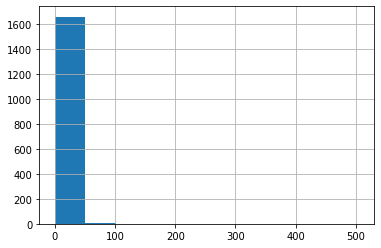

In [23]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count